In [1]:
import torch 
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## 降雨量数据描述性分析

In [2]:
df = pd.read_csv('../input/Rainfall_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Year               252 non-null    int64  
 1   Month              252 non-null    int64  
 2   Day                252 non-null    int64  
 3   Specific Humidity  252 non-null    float64
 4   Relative Humidity  252 non-null    float64
 5   Temperature        252 non-null    float64
 6   Precipitation      252 non-null    float64
dtypes: float64(4), int64(3)
memory usage: 13.9 KB


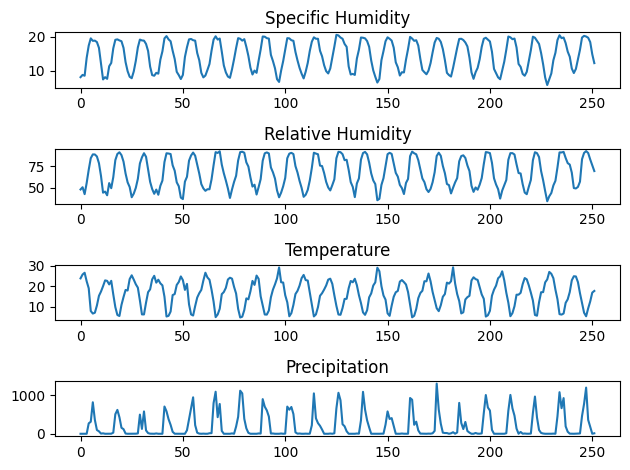

In [3]:
plt.subplot(4,1,1)
plt.plot(df['Specific Humidity'])
plt.title('Specific Humidity')
plt.subplot(4,1,2)
plt.plot(df['Relative Humidity'])
plt.title('Relative Humidity')
plt.subplot(4,1,3)
plt.plot(df['Temperature'])
plt.title('Temperature')
plt.subplot(4,1,4)
plt.plot(df['Precipitation'])
plt.title('Precipitation')
plt.tight_layout()
plt.show()

## 单变量预测
单独对precipitation进行预测，使用常见的手段
- AR
- MA 
- ARMA
- ARIMA
- RNN

1. ADF :  -2.4663249017732696
2. P-Value :  0.12388427626757847
3. Num of Lags :  12
4. Num of Observations Used For ADF Regression and Critical Values Calculation : 239
5. Critical Values :
	 1% :  -3.458010773719797
	 5% :  -2.8737103617125186
	 10% :  -2.5732559963936206


/home/step/anaconda3/envs/xclds/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


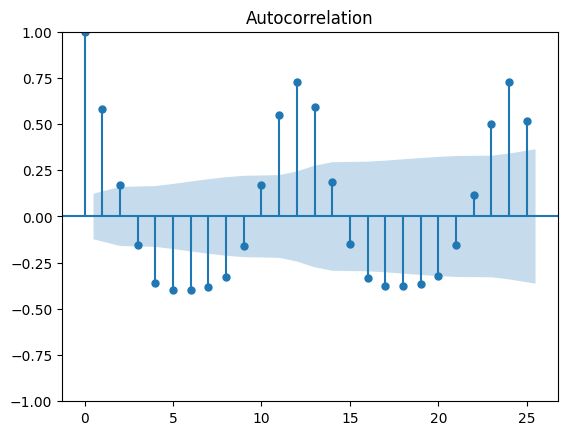

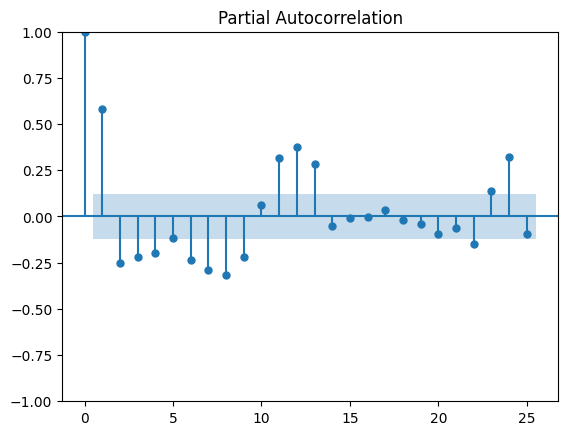

In [7]:
from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
    dftest = adfuller(dataset, autolag = 'AIC')
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num of Lags : ", dftest[2])
    print("4. Num of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)

adf_test(df['Precipitation'])

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['Precipitation'])
plot_pacf(df['Precipitation'])
plt.show()

Coefficients: [ 1.85436769e+02  2.27838198e-01 -1.10151484e-01 -1.71867462e-02
 -1.59595538e-01 -4.83664451e-02 -6.34817446e-02 -6.15113643e-02
 -7.67283834e-02 -1.75269389e-01  2.53038629e-02  1.64245436e-01
  3.75117893e-01]
predicted=-50.750678, expected=0.090000
predicted=-28.706576, expected=0.030000
predicted=-40.556376, expected=0.000000
predicted=0.170336, expected=0.130000
predicted=-69.608156, expected=1.850000
predicted=-71.531237, expected=0.180000
predicted=129.662086, expected=13.690000
predicted=458.476745, expected=600.760000
predicted=809.251661, expected=1012.110000
predicted=708.270349, expected=665.170000
predicted=456.812437, expected=472.090000
predicted=143.348997, expected=135.570000
predicted=-38.699775, expected=0.940000
predicted=-31.809217, expected=47.280000
predicted=-15.957828, expected=2.070000
predicted=-16.405432, expected=6.420000
predicted=-73.615242, expected=1.480000
predicted=-71.116771, expected=1.030000
predicted=150.993285, expected=5.220000
pr

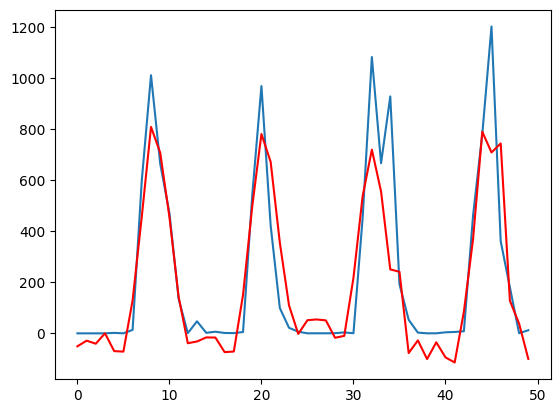

In [45]:
from statsmodels.tsa.ar_model import AutoReg

# Train the model and gets the params
x = df['Precipitation'].values
train, test = x[:len(x)-50], x[len(x)-50:]
p = 12
model = AutoReg(train, lags = p)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
params = model_fit.params

# Walk forward over time steps in test
history = train[len(train)-p:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-p,length)]
    yhat = params[0]
    for d in range(p):
        yhat += params[d+1] * lag[p-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

# Evaluate forecasts
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

/home/step/anaconda3/envs/xclds/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Coefficients: [-7.48687839e-01 -8.90549559e-01 -8.51629503e-01 -9.11741186e-01
 -8.84763249e-01 -8.77597007e-01 -8.78054015e-01 -8.87885546e-01
 -9.61347312e-01 -8.54813730e-01 -6.18486313e-01 -2.97139177e-01
 -1.18103476e-01  3.18050709e+04]
mse is: 26898.08919836664


/home/step/anaconda3/envs/xclds/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


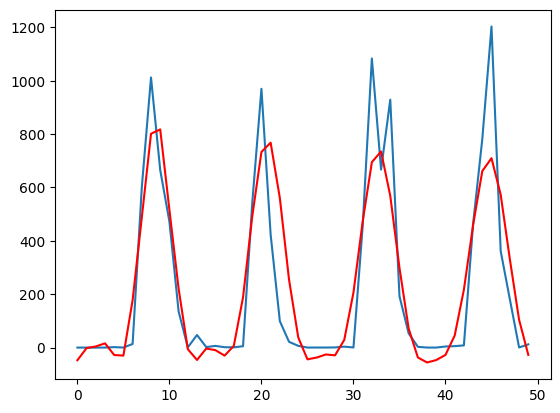

In [9]:
from statsmodels.tsa.arima.model import ARIMA
p = 12
i = 1
q = 1
model = ARIMA(train, order=(p,i,q))
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
params = model_fit.params

# Walk forward over time steps in test
fc = model_fit.forecast(len(test), alpha=0.05)
# fc, se, conf = model_fit.forecast(50, alpha=0.05)  # 95% conf
# fc_series = pd.Series(fc, index=test.index)
# lower_series = pd.Series(conf[:, 0], index=test.index)
# upper_series = pd.Series(conf[:, 1], index=test.index)
plt.plot(test)
plt.plot(fc, color='red')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
# plt.title("Final Forecast of Precipitation")
print('mse is:',mean_squared_error(test, fc))
plt.show()

In [46]:
print('The length of the dataset is:',len(train))
print('The length of the test set is:',len(test))
window_size = 12
def input_data(seq,ws):
    output = []
    for i in range(len(seq)-ws):
        output.append(seq[i:i+ws])
    return np.array(output)

train_set = input_data(train,window_size)
test_set = input_data(test,window_size)
print(train_set)

The length of the dataset is: 202
The length of the test set is: 50
[[0.0000e+00 1.1000e-01 1.0000e-02 ... 6.3410e+01 4.3700e+00 1.1250e+01]
 [1.1000e-01 1.0000e-02 2.0000e-02 ... 4.3700e+00 1.1250e+01 0.0000e+00]
 [1.0000e-02 2.0000e-02 2.7114e+02 ... 1.1250e+01 0.0000e+00 0.0000e+00]
 ...
 [1.2229e+02 3.0796e+02 7.2070e+01 ... 9.3900e+00 5.3552e+02 1.0094e+03]
 [3.0796e+02 7.2070e+01 2.9460e+01 ... 5.3552e+02 1.0094e+03 6.8420e+02]
 [7.2070e+01 2.9460e+01 0.0000e+00 ... 1.0094e+03 6.8420e+02 6.0637e+02]]


In [47]:
input_tensor = torch.Tensor(train_set)
test_set = torch.Tensor(test_set)

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, train_set):
        self.train_set = train_set

    def __getitem__(self, index):
        return self.train_set[index,:11], self.train_set[index,-1]

    def __len__(self):
        return len(self.train_set)

train_dataset = MyDataset(input_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=False)

for x,y in train_loader:
    print(x.shape,y.shape)
    break

torch.Size([16, 11]) torch.Size([16])


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MyRnn(nn.Module):
    def __init__(self, input_size,hidden_size,num_layers,output_size):
        '''
        input_size: number of features
        hidden_size: number of hidden units
        num_layers: number of layers
        output_size: number of output
        '''
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

input_size = 1
hidden_size = 128
num_layers = 2
output_size = 1

model = MyRnn(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5000
for epoch in range(num_epochs):
    for x,y in train_loader:
        x.unsqueeze_(-1)
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        loss = criterion(output, y.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print('Epoch: {}, Loss: {:.5f}'.format(epoch, loss.item()/len(x)))



Epoch: 0, Loss: 11318.88616
Epoch: 100, Loss: 7576.33538
Epoch: 200, Loss: 5106.74498
Epoch: 300, Loss: 3915.68052
Epoch: 400, Loss: 2197.17606
Epoch: 500, Loss: 1447.40458
Epoch: 600, Loss: 1273.75865
Epoch: 700, Loss: 888.67208
Epoch: 800, Loss: 531.91779
Epoch: 900, Loss: 578.11039
Epoch: 1000, Loss: 625.96010
Epoch: 1100, Loss: 704.02839
Epoch: 1200, Loss: 19.14759
Epoch: 1300, Loss: 37.05365
Epoch: 1400, Loss: 15.04235
Epoch: 1500, Loss: 0.74552
Epoch: 1600, Loss: 0.09028
Epoch: 1700, Loss: 1.35761
Epoch: 1800, Loss: 2377.29576
Epoch: 1900, Loss: 1.62876
Epoch: 2000, Loss: 1.64541
Epoch: 2100, Loss: 2.40658
Epoch: 2200, Loss: 2.34615
Epoch: 2300, Loss: 1.53580
Epoch: 2400, Loss: 1.30751
Epoch: 2500, Loss: 21.30806
Epoch: 2600, Loss: 2.00634
Epoch: 2700, Loss: 62.10046
Epoch: 2800, Loss: 0.55564
Epoch: 2900, Loss: 0.22726
Epoch: 3000, Loss: 0.07149
Epoch: 3100, Loss: 2.19256
Epoch: 3200, Loss: 0.55234
Epoch: 3300, Loss: 0.46995
Epoch: 3400, Loss: 2.84135
Epoch: 3500, Loss: 1.82410


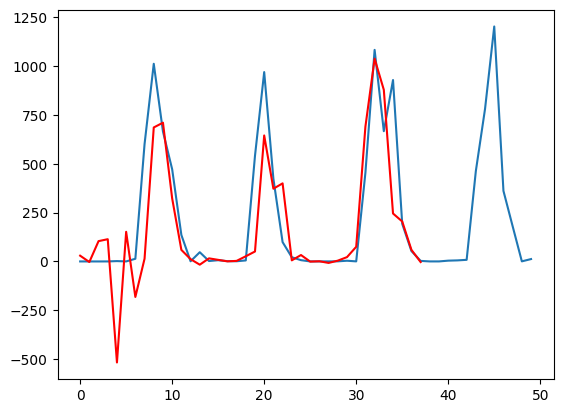

In [15]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)
list1 = []
for x in test_loader:
    x.unsqueeze_(-1)
    x = x.to(device)
    output = model(x)
    list1.append(output.item())
plt.plot(test)
plt.plot(list1, color='red')


## 多变量RNN预测

In [44]:
dataset = df.iloc[:,3:7].values
train_set = dataset[:len(dataset)-50]
test_set = dataset[len(dataset)-50:]

WINDOWS_SIZE = 12
def input_data(seq,ws):
    output = []
    for i in range(len(seq)-ws):
        output.append(seq[i:i+ws])
    return np.array(output)

train_set = input_data(train_set,WINDOWS_SIZE)
test_set = input_data(test_set,WINDOWS_SIZE)

input_tensor = torch.Tensor(train_set)
test_set = torch.Tensor(test_set)

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, train_set):
        self.train_set = train_set

    def __getitem__(self, index):
        return self.train_set[index,:11], self.train_set[index,-1]

    def __len__(self):
        return len(self.train_set)

train_dataset = MyDataset(input_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_dataset = MyDataset(test_set)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

input_size = 4
model = MyRnn(input_size, hidden_size, num_layers, output_size).to(device)
epochs = 500
for epoch in range(epochs):
    for x,y in train_loader:
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        loss = criterion(output, y.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

921.2453002929688
1499.418701171875
1789.864990234375
2643.08447265625
4071.7607421875
2254.60009765625
1489.663818359375
3762.19775390625
1355.587890625
1850.6834716796875
2923.5205078125
2976.200613839286
921.2453002929688
1499.418701171875
1789.864990234375
2643.08447265625
4071.7607421875
2254.60009765625
1489.663818359375
3762.19775390625
1355.587890625
1850.6834716796875
2923.5205078125
2976.200613839286
921.2453002929688
1499.418701171875
1789.864990234375
2643.08447265625
4071.7607421875
2254.60009765625
1489.663818359375
3762.19775390625
1355.587890625
1850.6834716796875
2923.5205078125
2976.200613839286
921.2453002929688
1499.418701171875
1789.864990234375
2643.08447265625
4071.7607421875
2254.60009765625
1489.663818359375
3762.19775390625
1355.587890625
1850.6834716796875
2923.5205078125
2976.200613839286
921.2453002929688
1499.418701171875
1789.864990234375
2643.08447265625
4071.7607421875
2254.60009765625
1489.663818359375
3762.19775390625
1355.587890625
1850.6834716796875

In [50]:
batchsize = 16
seq_len = 12
dim = 4
num_layers = 2
hidden_size = 128

input_batch = torch.randn(batchsize, seq_len, dim)
hidden = torch.randn(num_layers,batchsize, hidden_size)

myrnn = nn.RNN(input_size=dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
output, hidden = myrnn(input_batch, hidden)
print(output.shape)
print(hidden.shape)

torch.Size([16, 12, 128])
torch.Size([2, 16, 128])


In [50]:
class MyGRU(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden=None):
        if hidden is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        else:
            h0 = hidden
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

input_size = 1
hidden_size = 128
num_layers = 2
output_size = 1

newmodel = MyGRU(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(newmodel.parameters(), lr=0.01)

num_epochs = 5000
for epoch in range(num_epochs):
    running_loss = 0
    for x,y in train_loader:
        x = x.to(device)
        x.unsqueeze_(-1)
        y = y.to(device)
        output = newmodel(x)
        loss = criterion(output, y.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    if epoch % 100 == 0:
        print('Epoch: {}, Loss: {:.5f}'.format(epoch, running_loss/len(train_loader)))

Epoch: 0, Loss: 135669.43913
Epoch: 100, Loss: 32793.72257
Epoch: 200, Loss: 21342.32908
Epoch: 300, Loss: 17519.74400
Epoch: 400, Loss: 12286.22479
Epoch: 500, Loss: 7941.58347
Epoch: 600, Loss: 13002.03341
Epoch: 700, Loss: 5079.82041
Epoch: 800, Loss: 7814.14034
Epoch: 900, Loss: 9949.34527
Epoch: 1000, Loss: 10266.85282
Epoch: 1100, Loss: 9798.80798
Epoch: 1200, Loss: 6766.30721
Epoch: 1300, Loss: 23039.36523
Epoch: 1400, Loss: 18092.50612
Epoch: 1500, Loss: 15712.65004
Epoch: 1600, Loss: 22788.99386
Epoch: 1700, Loss: 18993.64396
Epoch: 1800, Loss: 10503.10319
Epoch: 1900, Loss: 13755.65151
Epoch: 2000, Loss: 13134.51668
Epoch: 2100, Loss: 8897.77050
Epoch: 2200, Loss: 26380.17155
Epoch: 2300, Loss: 10933.14257
Epoch: 2400, Loss: 12197.18744
Epoch: 2500, Loss: 11637.74632
Epoch: 2600, Loss: 11875.38635
Epoch: 2700, Loss: 9626.53898
Epoch: 2800, Loss: 26704.84538
Epoch: 2900, Loss: 14129.65432
Epoch: 3000, Loss: 11453.96006
Epoch: 3100, Loss: 24267.00997
Epoch: 3200, Loss: 14877.78

In [37]:
for X,y in train_loader:
    X = X.to(device)
    y = y.to(device)
    output = newmodel(X)
    print(output.shape)
    break

torch.Size([16, 1])


In [40]:
class MyLSTM(nn.Module):
    def __init__(self, input_size,hidden_size,num_layers,output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0,c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = 1
hidden_size = 128
num_layers = 2
output_size = 1

model = MyLSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

num_epochs = 500
for epoch in range(num_epochs):
    running_loss = 0
    for x,y in train_loader:
        x = x.to(device)
        y = y.to(device)
        output = model(x)
        loss = criterion(output, y.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    if epoch % 100 == 0:
        print('Epoch: {}, Loss: {:.5f}'.format(epoch, running_loss/len(train_loader)))

AttributeError: 'tuple' object has no attribute 'dim'